**1. Данные**

In [1]:
!pip install gdown

In [2]:
!gdown "https://drive.google.com/file/d/1j3Pey7vhGA5_OYrjos-gDwv5_gm7BPBO/view?usp=sharing" --fuzzy -O handout.tar.gz

Downloading...
From (original): https://drive.google.com/uc?id=1j3Pey7vhGA5_OYrjos-gDwv5_gm7BPBO
From (redirected): https://drive.google.com/uc?id=1j3Pey7vhGA5_OYrjos-gDwv5_gm7BPBO&confirm=t&uuid=8ae5315b-6c44-4662-aba2-259521be4382
To: /content/handout.tar.gz
100% 884M/884M [00:11<00:00, 77.9MB/s]


In [8]:
!mkdir -p data
!tar -xzf handout.tar.gz

In [9]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

CPU times: user 122 ms, sys: 376 ms, total: 497 ms
Wall time: 498 ms


In [10]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


In [11]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i]
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

In [12]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

# Compute word frequencies for each word in captions. See code above for data structure
for img_captions in captions:
  for caption in img_captions:
    for word in caption:
      word_counts[word] += 1

In [13]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [14]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))

    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [15]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

**2. Построение нейронной сети**

In [16]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [17]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()

        # a layer that converts conv features to initial LSTM state
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)

        # create embedding for input words
        self.emb = nn.Embedding(num_embeddings=n_tokens, embedding_dim=emb_size, padding_idx=pad_ix)

        # lstm: recurrent core
        self.lstm = nn.LSTM(
            input_size=emb_size,
            hidden_size=lstm_units,
            batch_first=True
        )

        # linear layer to map LSTM hidden states to logits over vocabulary
        self.logits = nn.Linear(lstm_units, n_tokens)

    def forward(self, image_vectors, captions_ix):
        """
        Apply the network in training mode.
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i].
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)  # [batch, lstm_units]
        initial_hid = self.cnn_to_h0(image_vectors)   # [batch, lstm_units]

        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix)  # [batch, seq_len, emb_size]

        # initialize LSTM hidden and cell states
        # nn.LSTM expects (num_layers, batch, hidden_size), so we add a dimension
        h0 = initial_hid.unsqueeze(0)  # [1, batch, lstm_units]
        c0 = initial_cell.unsqueeze(0)  # [1, batch, lstm_units]

        # apply LSTM
        lstm_out, _ = self.lstm(captions_emb, (h0, c0))  # [batch, seq_len, lstm_units]

        # compute logits from lstm_out
        logits = self.logits(lstm_out)  # [batch, seq_len, n_tokens]

        return logits

In [18]:
network = CaptionNet(n_tokens)

In [19]:
dummy_img_vec = torch.randn(len(captions[0]), 2048)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logis = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logis.shape)
assert dummy_logis.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [20]:
def compute_loss(network, image_vectors, caption_ix):
  caption_ix_inp = caption_ix[:, :-1].contiguous()
  caption_ix_next = caption_ix[:, 1:].contiguous()

  logits_for_next = network.forward(image_vectors, caption_ix_inp)

  loss_fn = nn.CrossEntropyLoss(ignore_index=pad_ix)

  batch_size, seq_len, n_tokens = logits_for_next.shape
  logits_flat = logits_for_next.reshape(-1, n_tokens)
  targets_flat = caption_ix_next.reshape(-1)

  loss = loss_fn(logits_flat, targets_flat).unsqueeze(0)

  return loss


In [21]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert dummy_loss.shape == torch.Size([1]), 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

In [22]:
optimizer = torch.optim.Adam(
    network.parameters(),
    lr=3e-4,
    weight_decay=1e-5
)

**3. Обучение**

In [23]:
from sklearn.model_selection import train_test_split

train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions, test_size=0.1, random_state=42)

In [24]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):

  random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)

  batch_images = img_codes[random_image_ix]

  captions_for_batch_images = [captions[i] for i in random_image_ix]

  batch_captions = list(map(choice, captions_for_batch_images))

  batch_captions_ix = as_matrix(batch_captions, max_len=max_caption_len)

  return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)

In [25]:
generate_batch(img_codes, captions, 3)

(tensor([[0.4230, 0.1060, 0.3659,  ..., 0.2765, 1.0187, 0.4400],
         [0.0245, 0.0973, 0.0730,  ..., 0.0683, 0.8157, 0.0222],
         [0.1902, 0.4464, 0.2465,  ..., 0.4297, 0.1764, 0.2684]]),
 tensor([[   1,  360,   17,  112,  928, 1371, 2436,  503,   35,   45,   71,   12,
             2,    3],
         [   1,   24,   57,   15,   24,  278,  279,   94,  120,   51,  747,  541,
          3042,    2],
         [   1,   45,   88,    4,   17,  611, 2011, 1371,   35,   45,  155,   12,
             2,    3]]))

In [26]:
batch_size = 50
n_epochs = 100
n_batches_per_epoch = 50
n_validation_batches = 5

In [27]:
from tqdm import tqdm

for epoch in range(n_epochs):

    train_loss = 0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):

        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))

        # clear old gradients; do a backward pass to get new gradients; then train with opt
        optimizer.zero_grad()      # обнуляем градиенты с прошлой итерации
        loss_t.backward()          # вычисляем градиенты
        optimizer.step()           # обновляем веса

        train_loss += loss_t.item()

    train_loss /= n_batches_per_epoch

    val_loss = 0
    network.train(False)
    for _ in range(n_validation_batches):
        with torch.no_grad():  # отключаем вычисление градиентов для валидации (экономия памяти и скорости)
            loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
            val_loss += loss_t.item()
    val_loss /= n_validation_batches

    print('\nEpoch: {}, train loss: {:.4f}, val loss: {:.4f}'.format(epoch, train_loss, val_loss))

print("Finished!")

100%|██████████| 50/50 [00:17<00:00,  2.90it/s]



Epoch: 0, train loss: 7.3936, val loss: 5.4311


100%|██████████| 50/50 [00:17<00:00,  2.84it/s]



Epoch: 1, train loss: 5.0908, val loss: 4.9387


100%|██████████| 50/50 [00:17<00:00,  2.87it/s]



Epoch: 2, train loss: 4.8813, val loss: 4.8051


100%|██████████| 50/50 [00:16<00:00,  3.06it/s]



Epoch: 3, train loss: 4.7953, val loss: 4.8702


100%|██████████| 50/50 [00:18<00:00,  2.72it/s]



Epoch: 4, train loss: 4.6628, val loss: 4.6857


100%|██████████| 50/50 [00:16<00:00,  2.95it/s]



Epoch: 5, train loss: 4.5776, val loss: 4.6335


100%|██████████| 50/50 [00:17<00:00,  2.78it/s]



Epoch: 6, train loss: 4.5072, val loss: 4.3904


100%|██████████| 50/50 [00:17<00:00,  2.87it/s]



Epoch: 7, train loss: 4.4408, val loss: 4.3876


100%|██████████| 50/50 [00:17<00:00,  2.93it/s]



Epoch: 8, train loss: 4.3639, val loss: 4.2221


100%|██████████| 50/50 [00:16<00:00,  3.00it/s]



Epoch: 9, train loss: 4.2912, val loss: 4.2004


100%|██████████| 50/50 [00:17<00:00,  2.86it/s]



Epoch: 10, train loss: 4.2467, val loss: 4.1320


100%|██████████| 50/50 [00:18<00:00,  2.74it/s]



Epoch: 11, train loss: 4.1599, val loss: 4.1695


100%|██████████| 50/50 [00:16<00:00,  2.97it/s]



Epoch: 12, train loss: 4.1316, val loss: 4.0535


100%|██████████| 50/50 [00:15<00:00,  3.24it/s]



Epoch: 13, train loss: 4.0628, val loss: 4.0710


100%|██████████| 50/50 [00:16<00:00,  2.94it/s]



Epoch: 14, train loss: 4.0952, val loss: 4.0846


100%|██████████| 50/50 [00:17<00:00,  2.82it/s]



Epoch: 15, train loss: 4.0399, val loss: 4.0982


100%|██████████| 50/50 [00:16<00:00,  2.96it/s]



Epoch: 16, train loss: 3.9682, val loss: 3.9802


100%|██████████| 50/50 [00:16<00:00,  3.07it/s]



Epoch: 17, train loss: 3.9310, val loss: 3.9696


100%|██████████| 50/50 [00:17<00:00,  2.90it/s]



Epoch: 18, train loss: 3.8989, val loss: 3.9760


100%|██████████| 50/50 [00:16<00:00,  3.02it/s]



Epoch: 19, train loss: 3.8643, val loss: 3.7623


100%|██████████| 50/50 [00:16<00:00,  3.01it/s]



Epoch: 20, train loss: 3.8445, val loss: 3.8820


100%|██████████| 50/50 [00:17<00:00,  2.85it/s]



Epoch: 21, train loss: 3.8270, val loss: 3.7990


100%|██████████| 50/50 [00:17<00:00,  2.82it/s]



Epoch: 22, train loss: 3.7635, val loss: 3.7298


100%|██████████| 50/50 [00:17<00:00,  2.80it/s]



Epoch: 23, train loss: 3.7647, val loss: 3.7481


100%|██████████| 50/50 [00:17<00:00,  2.87it/s]



Epoch: 24, train loss: 3.7329, val loss: 3.7335


100%|██████████| 50/50 [00:17<00:00,  2.82it/s]



Epoch: 25, train loss: 3.7072, val loss: 3.6346


100%|██████████| 50/50 [00:17<00:00,  2.82it/s]



Epoch: 26, train loss: 3.6757, val loss: 3.6585


100%|██████████| 50/50 [00:17<00:00,  2.89it/s]



Epoch: 27, train loss: 3.6560, val loss: 3.5944


100%|██████████| 50/50 [00:17<00:00,  2.85it/s]



Epoch: 28, train loss: 3.6416, val loss: 3.6105


100%|██████████| 50/50 [00:18<00:00,  2.74it/s]



Epoch: 29, train loss: 3.5975, val loss: 3.6038


100%|██████████| 50/50 [00:17<00:00,  2.91it/s]



Epoch: 30, train loss: 3.5627, val loss: 3.6867


100%|██████████| 50/50 [00:16<00:00,  3.00it/s]



Epoch: 31, train loss: 3.5662, val loss: 3.4940


100%|██████████| 50/50 [00:16<00:00,  3.03it/s]



Epoch: 32, train loss: 3.5578, val loss: 3.6746


100%|██████████| 50/50 [00:18<00:00,  2.72it/s]



Epoch: 33, train loss: 3.4976, val loss: 3.5387


100%|██████████| 50/50 [00:17<00:00,  2.94it/s]



Epoch: 34, train loss: 3.4847, val loss: 3.5164


100%|██████████| 50/50 [00:17<00:00,  2.92it/s]



Epoch: 35, train loss: 3.4932, val loss: 3.5126


100%|██████████| 50/50 [00:19<00:00,  2.62it/s]



Epoch: 36, train loss: 3.4585, val loss: 3.5352


100%|██████████| 50/50 [00:17<00:00,  2.89it/s]



Epoch: 37, train loss: 3.4442, val loss: 3.2461


100%|██████████| 50/50 [00:17<00:00,  2.86it/s]



Epoch: 38, train loss: 3.4100, val loss: 3.4018


100%|██████████| 50/50 [00:18<00:00,  2.74it/s]



Epoch: 39, train loss: 3.4404, val loss: 3.5162


100%|██████████| 50/50 [00:17<00:00,  2.89it/s]



Epoch: 40, train loss: 3.3970, val loss: 3.4136


100%|██████████| 50/50 [00:17<00:00,  2.87it/s]



Epoch: 41, train loss: 3.3839, val loss: 3.4590


100%|██████████| 50/50 [00:17<00:00,  2.92it/s]



Epoch: 42, train loss: 3.3683, val loss: 3.3725


100%|██████████| 50/50 [00:15<00:00,  3.15it/s]



Epoch: 43, train loss: 3.3350, val loss: 3.3184


100%|██████████| 50/50 [00:16<00:00,  3.06it/s]



Epoch: 44, train loss: 3.3287, val loss: 3.2727


100%|██████████| 50/50 [00:18<00:00,  2.72it/s]



Epoch: 45, train loss: 3.3124, val loss: 3.3660


100%|██████████| 50/50 [00:16<00:00,  3.01it/s]



Epoch: 46, train loss: 3.3239, val loss: 3.2464


100%|██████████| 50/50 [00:16<00:00,  3.09it/s]



Epoch: 47, train loss: 3.3020, val loss: 3.3197


100%|██████████| 50/50 [00:15<00:00,  3.31it/s]



Epoch: 48, train loss: 3.2659, val loss: 3.1929


100%|██████████| 50/50 [00:17<00:00,  2.79it/s]



Epoch: 49, train loss: 3.3054, val loss: 3.4459


100%|██████████| 50/50 [00:16<00:00,  2.98it/s]



Epoch: 50, train loss: 3.2711, val loss: 3.1928


100%|██████████| 50/50 [00:17<00:00,  2.83it/s]



Epoch: 51, train loss: 3.2170, val loss: 3.2004


100%|██████████| 50/50 [00:18<00:00,  2.63it/s]



Epoch: 52, train loss: 3.2655, val loss: 3.3723


100%|██████████| 50/50 [00:17<00:00,  2.80it/s]



Epoch: 53, train loss: 3.2348, val loss: 3.2060


100%|██████████| 50/50 [00:16<00:00,  3.02it/s]



Epoch: 54, train loss: 3.2560, val loss: 3.3264


100%|██████████| 50/50 [00:17<00:00,  2.87it/s]



Epoch: 55, train loss: 3.2030, val loss: 3.2622


100%|██████████| 50/50 [00:17<00:00,  2.85it/s]



Epoch: 56, train loss: 3.1903, val loss: 3.2439


100%|██████████| 50/50 [00:16<00:00,  2.95it/s]



Epoch: 57, train loss: 3.1559, val loss: 3.3085


100%|██████████| 50/50 [00:17<00:00,  2.86it/s]



Epoch: 58, train loss: 3.1513, val loss: 3.2493


100%|██████████| 50/50 [00:16<00:00,  3.03it/s]



Epoch: 59, train loss: 3.1104, val loss: 3.0751


100%|██████████| 50/50 [00:17<00:00,  2.92it/s]



Epoch: 60, train loss: 3.1565, val loss: 3.1633


100%|██████████| 50/50 [00:17<00:00,  2.81it/s]



Epoch: 61, train loss: 3.1561, val loss: 3.0683


100%|██████████| 50/50 [00:16<00:00,  3.06it/s]



Epoch: 62, train loss: 3.1006, val loss: 2.9827


100%|██████████| 50/50 [00:17<00:00,  2.90it/s]



Epoch: 63, train loss: 3.1642, val loss: 3.0857


100%|██████████| 50/50 [00:17<00:00,  2.82it/s]



Epoch: 64, train loss: 3.1058, val loss: 3.0062


100%|██████████| 50/50 [00:17<00:00,  2.91it/s]



Epoch: 65, train loss: 3.1291, val loss: 3.1042


100%|██████████| 50/50 [00:17<00:00,  2.93it/s]



Epoch: 66, train loss: 3.0655, val loss: 3.1328


100%|██████████| 50/50 [00:16<00:00,  3.00it/s]



Epoch: 67, train loss: 3.0747, val loss: 3.0862


100%|██████████| 50/50 [00:18<00:00,  2.71it/s]



Epoch: 68, train loss: 3.0774, val loss: 3.0028


100%|██████████| 50/50 [00:17<00:00,  2.81it/s]



Epoch: 69, train loss: 3.0524, val loss: 3.1439


100%|██████████| 50/50 [00:18<00:00,  2.65it/s]



Epoch: 70, train loss: 3.0814, val loss: 3.1155


100%|██████████| 50/50 [00:16<00:00,  2.98it/s]



Epoch: 71, train loss: 3.0935, val loss: 3.1945


100%|██████████| 50/50 [00:16<00:00,  2.97it/s]



Epoch: 72, train loss: 3.0735, val loss: 3.0237


100%|██████████| 50/50 [00:17<00:00,  2.82it/s]



Epoch: 73, train loss: 3.0610, val loss: 3.0866


100%|██████████| 50/50 [00:16<00:00,  3.02it/s]



Epoch: 74, train loss: 3.0603, val loss: 3.0404


100%|██████████| 50/50 [00:17<00:00,  2.83it/s]



Epoch: 75, train loss: 3.0219, val loss: 3.0814


100%|██████████| 50/50 [00:17<00:00,  2.82it/s]



Epoch: 76, train loss: 3.0186, val loss: 3.0117


100%|██████████| 50/50 [00:17<00:00,  2.79it/s]



Epoch: 77, train loss: 3.0405, val loss: 2.9034


100%|██████████| 50/50 [00:16<00:00,  2.98it/s]



Epoch: 78, train loss: 3.0279, val loss: 2.9182


100%|██████████| 50/50 [00:17<00:00,  2.86it/s]



Epoch: 79, train loss: 3.0400, val loss: 3.0562


100%|██████████| 50/50 [00:18<00:00,  2.76it/s]



Epoch: 80, train loss: 2.9939, val loss: 2.9640


100%|██████████| 50/50 [00:15<00:00,  3.21it/s]



Epoch: 81, train loss: 2.9852, val loss: 2.9628


100%|██████████| 50/50 [00:17<00:00,  2.83it/s]



Epoch: 82, train loss: 3.0294, val loss: 3.0075


100%|██████████| 50/50 [00:18<00:00,  2.69it/s]



Epoch: 83, train loss: 2.9903, val loss: 2.9156


100%|██████████| 50/50 [00:16<00:00,  2.95it/s]



Epoch: 84, train loss: 2.9817, val loss: 2.9228


100%|██████████| 50/50 [00:16<00:00,  3.05it/s]



Epoch: 85, train loss: 2.9345, val loss: 2.9695


100%|██████████| 50/50 [00:18<00:00,  2.65it/s]



Epoch: 86, train loss: 2.9635, val loss: 2.8988


100%|██████████| 50/50 [00:17<00:00,  2.87it/s]



Epoch: 87, train loss: 2.9962, val loss: 2.9293


100%|██████████| 50/50 [00:16<00:00,  2.95it/s]



Epoch: 88, train loss: 2.9933, val loss: 2.9411


100%|██████████| 50/50 [00:18<00:00,  2.66it/s]



Epoch: 89, train loss: 2.9447, val loss: 2.8988


100%|██████████| 50/50 [00:17<00:00,  2.89it/s]



Epoch: 90, train loss: 2.9423, val loss: 3.0106


100%|██████████| 50/50 [00:16<00:00,  3.04it/s]



Epoch: 91, train loss: 2.9225, val loss: 2.9216


100%|██████████| 50/50 [00:17<00:00,  2.89it/s]



Epoch: 92, train loss: 2.9701, val loss: 2.8731


100%|██████████| 50/50 [00:17<00:00,  2.87it/s]



Epoch: 93, train loss: 2.9270, val loss: 3.0059


100%|██████████| 50/50 [00:17<00:00,  2.88it/s]



Epoch: 94, train loss: 2.9462, val loss: 2.9737


100%|██████████| 50/50 [00:17<00:00,  2.79it/s]



Epoch: 95, train loss: 2.9308, val loss: 2.8797


100%|██████████| 50/50 [00:17<00:00,  2.89it/s]



Epoch: 96, train loss: 2.9341, val loss: 2.9125


100%|██████████| 50/50 [00:17<00:00,  2.80it/s]



Epoch: 97, train loss: 2.9071, val loss: 2.8994


100%|██████████| 50/50 [00:17<00:00,  2.80it/s]



Epoch: 98, train loss: 2.9419, val loss: 2.8628


100%|██████████| 50/50 [00:16<00:00,  3.12it/s]



Epoch: 99, train loss: 2.9265, val loss: 2.9045
Finished!


**4. Применяем обученную модель**

In [28]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

/usr/local/lib/python3.12/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


100%|██████████| 104M/104M [00:00<00:00, 218MB/s] 


Генерируем подписи

In [29]:
def generate_caption(image, caption_prefix=("#START#",),
                     t=1, sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3

    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):

            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
            next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
            next_word_probs = F.softmax(next_word_logits, dim=-1).data.numpy()

            assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs)
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            if next_word == "#END#":
                break

    return caption_prefix

In [30]:
from matplotlib import pyplot as plt
from PIL import Image
import numpy as numpy
%matplotlib inline

# Скачиваем изображение
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg

# Загружаем и изменяем размер
img_pil = Image.open('data/img.jpg').convert('RGB')
img_resized = img_pil.resize((299, 299))  # (width, height)
img = np.array(img_resized).astype('float32') / 255.0

--2025-10-29 20:50:12--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 199.232.193.246, 199.232.197.246
Connecting to pixel.nymag.com (pixel.nymag.com)|199.232.193.246|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2025-10-29 20:50:13--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 199.232.193.246, 199.232.197.246
Connecting to pyxis.nymag.com (pyxis.nymag.com)|199.232.193.246|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  53.45K  --.-KB/s    in 0.008s  

2025-10-29 20:50:13 (6.36 MB/s) - ‘data/img.jpg’ saved [54731/547

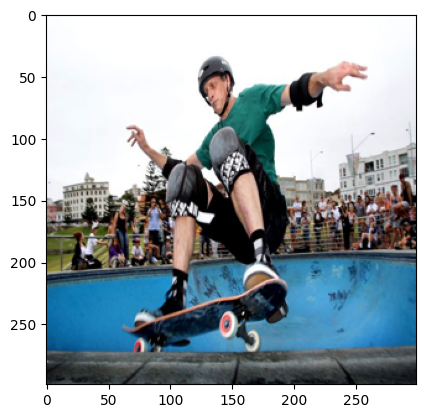

In [31]:
plt.imshow(img)

In [32]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man riding a skateboard on a skateboard .
a man is riding a skateboard on a skateboard .
a man riding a skateboard on a skateboard .
a man riding a skateboard on a skateboard .
a man in a skate park doing a trick on a skateboard .
a man in a skate board riding a skateboard on a skateboard .
a man riding a skateboard on a skateboard .
a man riding a skateboard on a skateboard .
a person on a skateboard on a skateboard .
a man riding a skateboard on a skateboard .
